# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

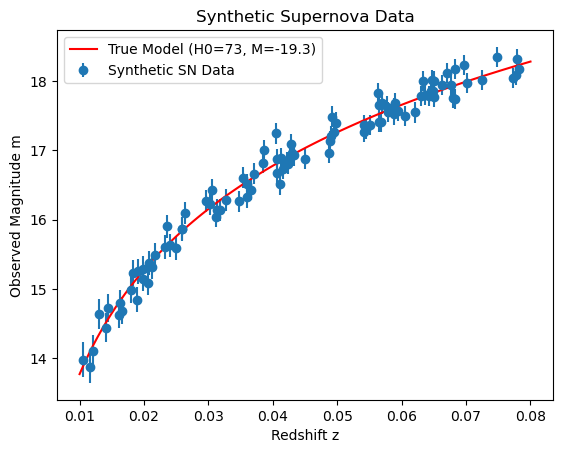

In [54]:
# TODO: generate and plot data with error bars

data = make_synthetic_sample(N=100, H0=73.0, M=-19.3, rng=42)
plt.errorbar(data.z, data.m, yerr=data.sigma_m, fmt='o', label='Synthetic SN Data')
plt.xlabel('Redshift z')
plt.ylabel('Observed Magnitude m')
plt.title('Synthetic Supernova Data')
plt.gca()
plt.legend()

#plot true model

z_fit = np.linspace(0.01, 0.08, 100)
m_true = mag_model(z_fit, H0=73.0, M=-19.3)
plt.plot(z_fit, m_true, 'r-', label='True Model (H0=73, M=-19.3)')
plt.legend()


plt.show()


### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [55]:
# TODO: define chi2 function
def chi2(theta, x, y, sigma):
    H0, M = theta
    model = mag_model(x, H0, M)
    return np.sum(((y - model) / sigma) ** 2)

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

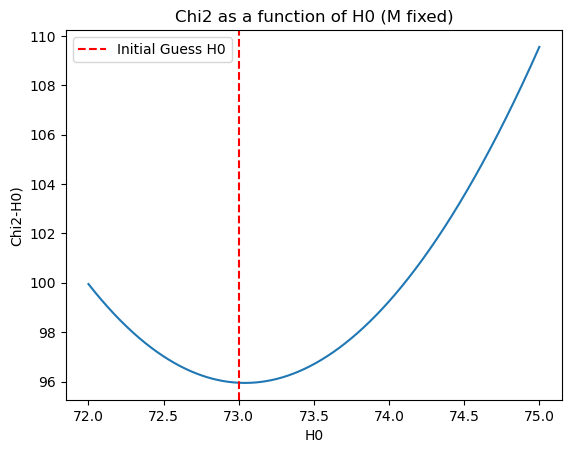

Best-fit H0 (M fixed at -19.3): 73.04


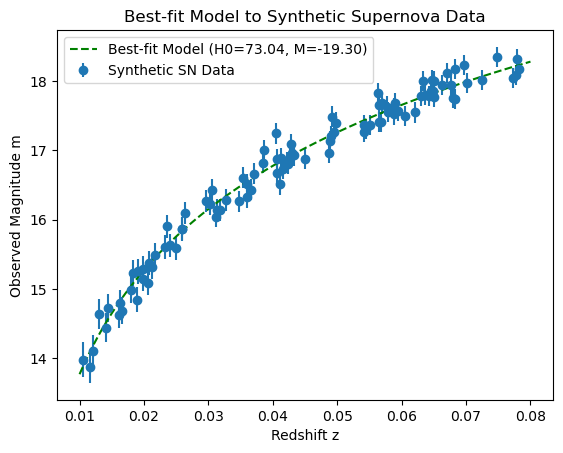

In [56]:
# TODO:  minimize chi2
# M is supposed constant
original_values = (73.0, -19.3)  # initial guess for (H0, M)

# Change H and calculate array of chi2 values

H_values = np.linspace(72, 75, 1000)
chi2_values = [chi2((H, original_values[1]), data.z, data.m, data.sigma_m) for H in H_values]
plt.plot(H_values, chi2_values)
plt.xlabel('H0')
plt.ylabel('Chi2-H0)')
plt.title('Chi2 as a function of H0 (M fixed)')
plt.axvline(original_values[0], color='r', linestyle='--', label='Initial Guess H0')
plt.legend()
plt.show()

#  best fit is corresponding H to lowest value of the array

min = np.argmin(chi2_values)
best_fit_H0 = H_values[min]
print(f"Best-fit H0 (M fixed at {original_values[1]}): {best_fit_H0:.2f}")






# plot best fit model

model_m = mag_model(z_fit, best_fit_H0, original_values[1])
plt.errorbar(data.z, data.m, yerr=data.sigma_m, fmt='o', label='Synthetic SN Data')
plt.plot(z_fit, model_m, 'g--', label=f'Best-fit Model (H0={best_fit_H0:.2f}, M={original_values[1]:.2f})')
plt.xlabel('Redshift z')
plt.ylabel('Observed Magnitude m')
plt.title('Best-fit Model to Synthetic Supernova Data')
plt.legend()
plt.show()


In [57]:
# TODO: say something about goodness of fit



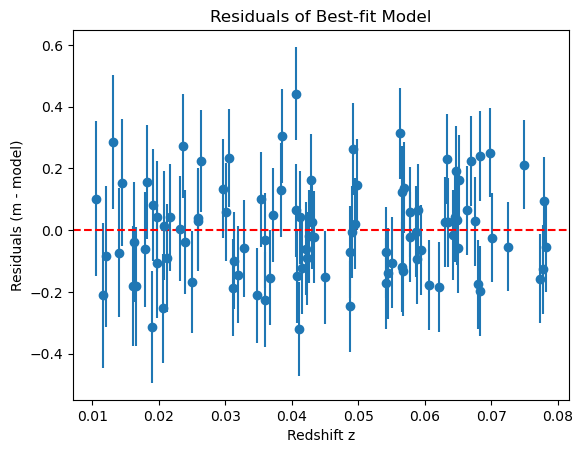

In [58]:
# TODO: plot residuals, always!
model_m = mag_model(data.z, best_fit_H0, original_values[1])
residuals = data.m - model_m
plt.errorbar(data.z, residuals, yerr=data.sigma_m, fmt='o')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Redshift z')
plt.ylabel('Residuals (m - model)')
plt.title('Residuals of Best-fit Model')
plt.show()

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

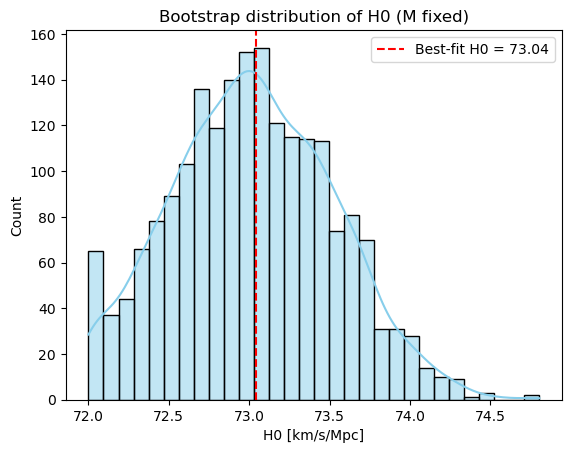

In [59]:
import seaborn as sns

H0_boot = []

n_bootstrap = 2000
rng = np.random.default_rng(12345)
for _ in range(n_bootstrap):
    indices = rng.integers(0, len(data.z), len(data.z))
    z_boot = data.z[indices]
    m_boot = data.m[indices]
    sigma_boot = data.sigma_m[indices]

    chi2_values_boot = [chi2((H, original_values[1]), z_boot, m_boot, sigma_boot) for H in H_values]
    min_boot = np.argmin(chi2_values_boot)
    best_fit_H0_boot = H_values[min_boot]
    H0_boot.append(best_fit_H0_boot)
H0_boot = np.array(H0_boot)
h_med = np.median(H0_boot)
H0_min = best_fit_H0

plt.figure()
sns.histplot(H0_boot, bins=30, kde=True, stat="count", color="skyblue", edgecolor="k")
plt.axvline(H0_min, color='r', linestyle='--', label=f'Best-fit H0 = {H0_min:.2f}')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Count')
plt.title('Bootstrap distribution of H0 (M fixed)')
plt.legend()
plt.show()

### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [60]:
# TODO: let's calculate a p-value from the sampled probability

dof = len(data.z) - 1  # degrees of freedom (N - number of fitted parameters)
chi2_min = chi2((H0_min, original_values[1]), data.z, data.m, data.sigma_m)
from scipy.stats import chi2 as chi2_dist
p_value = 1 - chi2_dist.cdf(chi2_min, dof)
print(f"Chi2 min: {chi2_min:.2f}, dof: {dof}, p-value: {p_value:.4f}")




Chi2 min: 95.94, dof: 99, p-value: 0.5683


### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

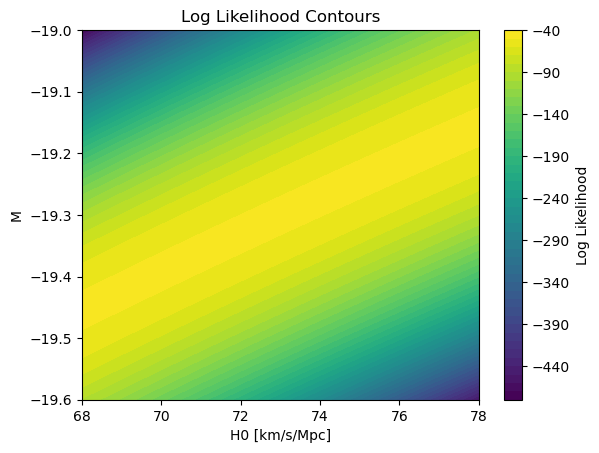

In [80]:
# TODO: implement grid posterior evaluation

H0_grid = np.linspace(68, 78, 200)
M_grid = np.linspace(-19.6, -19.0, 200)

H0_mesh, M_mesh = np.meshgrid(H0_grid, M_grid)

def log_likelihood(theta, x, y, sigma):
    H0, M = theta
    model = mag_model(x, H0, M)
    return -0.5 * np.sum(((y - model) / sigma) ** 2)

log_likelihood_values = np.array([[log_likelihood((H0, M), data.z, data.m, data.sigma_m)
                                    for H0 in H0_grid] for M in M_grid])

# PLOT log likelihood
# keep
plt.figure()
plt.contourf(H0_grid, M_grid, log_likelihood_values, levels=50, cmap='viridis')
plt.colorbar(label='Log Likelihood')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('M')
plt.title('Log Likelihood Contours')
plt.show()

# Compute joint posterior distribution from obtained result

# = likelihood * prior (gaussian prior on M and H0) (+ not time if log)

H0_prior = np.linspace(68, 78, 200)
# M prior is gaussian








In [102]:
!pip install corner

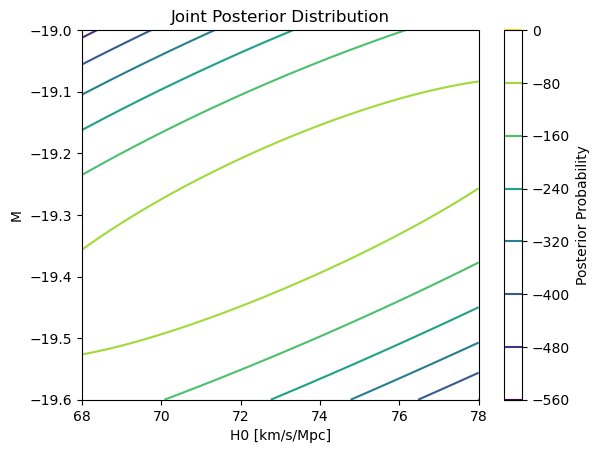

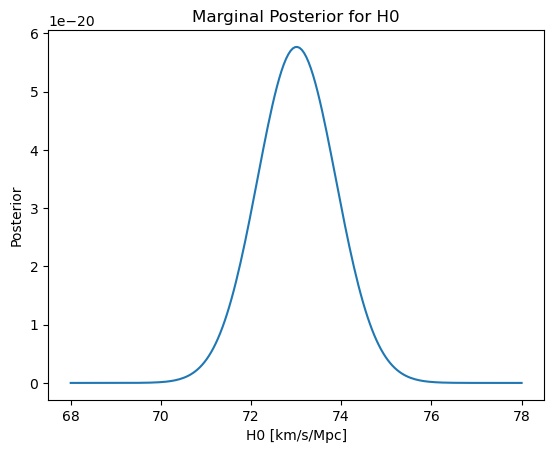

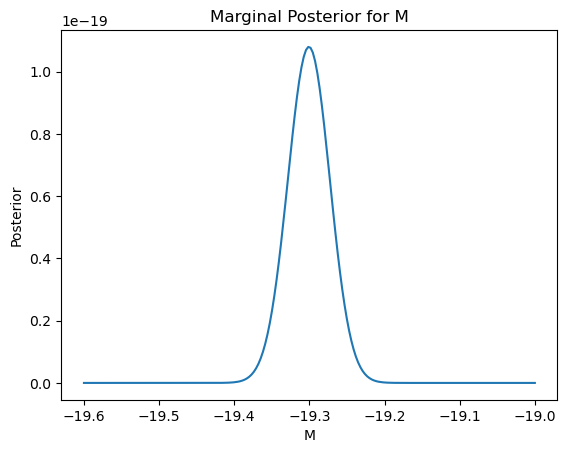

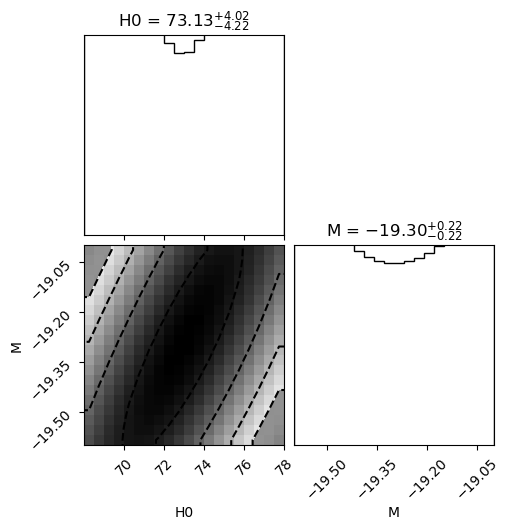

In [105]:
#  Gaussian priors for H0 and M
H0_mu, H0_sigma = 73.0, 1.0     # example prior for H0
M_mu, M_sigma = -19.3, 0.05      # example prior for M

def log_prior(H0, M):
    lp_H0 = -0.5 * ((H0 - H0_mu)/H0_sigma)**2 - np.log(H0_sigma*np.sqrt(2*np.pi))
    lp_M  = -0.5 * ((M - M_mu)/M_sigma)**2   - np.log(M_sigma*np.sqrt(2*np.pi))
    return lp_H0 + lp_M

# Compute log-posterior grid
log_posterior_values = np.zeros_like(log_likelihood_values)

for i, M in enumerate(M_grid):
    for j, H0 in enumerate(H0_grid):
        log_posterior_values[i, j] = log_likelihood_values[i, j] + log_prior(H0, M)


posterior = log_posterior_values

# Marginalize to get 1D posteriors
posterior_H0 = np.sum(np.exp(posterior), axis=0)   # sum over M
posterior_M  = np.sum(np.exp(posterior), axis=1)   # sum over H0


# Joint posterior
plt.figure()
plt.contour(H0_grid, M_grid, posterior, levels=6, cmap='viridis')
plt.colorbar(label='Posterior Probability')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('M')
plt.title('Joint Posterior Distribution')
plt.show()

#  H0
plt.figure()
plt.plot(H0_grid, posterior_H0)
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Posterior')
plt.title('Marginal Posterior for H0')
plt.show()

#  M
plt.figure()
plt.plot(M_grid, posterior_M)
plt.xlabel('M')
plt.ylabel('Posterior')
plt.title('Marginal Posterior for M')
plt.show()


# matplotlib corner plot
import corner
samples = np.array(np.meshgrid(H0_grid, M_grid)).T.reshape(-1, 2)
weights = posterior.flatten()
fig = corner.corner(samples, weights=weights, labels=['H0', 'M'], show_titles=True)
plt.show()



    ### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [1]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [ ]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare

In [107]:
import cobaya

In [118]:
# get 3 plots : likelihood, posterior, corner

def loglike_cobaya(H0,M):
    return -0.5*chi2((H0,M),data.z,data.m,data.sigma_m)

info_dict = {
    "params": {
        "H0": {"prior": {"min": 50, "max": 90}, "ref": 73.0, "latex": r"$H_0$"},
        "M": {"prior": {"dist" : "norm", "loc": -19.3, "scale": 0.05},"latex": r"$M$"},
    },
    "likelihood": {
        "my_likelihood": {
            "external": loglike_cobaya
        }
    },
    "sampler": {
        "mcmc": {
            "max_tries": 10000,
            "Rminus1_stop": 0.01,
        }
    },
}

In [119]:
# run cobaya
info, sampler = cobaya.run(info_dict)

[my_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: H0:73, M:-19.33326
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_likelihood: 45300.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-08-28 16:43:28 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.062
[mcmc]  - Convergence of means: R-1 = 0.203438 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 16

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.10875 
Mean:
[ 73.00496297 -19.30375515]
Covariance matrix:
[[2.72297196e+00 7.31990566e-02]
 [7.31990566e-02 2.19370905e-03]]


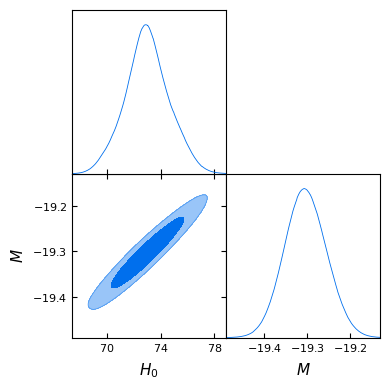

In [130]:
# plot results
gd_sample = sampler.products(to_getdist=True)["sample"]

# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["H0", "M"], filled=True)


In [143]:
# superpose all 3 curves for H0: one from cobaya, one from homemade grid and one from boostrap frequencist
# plot results
gd_sample = sampler.products()["sample"]

H0_cob_array = gd_sample["H0"]

homemade_array = posterior_H0

# norlalize cobaya

import seaborn as sns

hist = sns.histplot(data=np.array(H0_cob_array), x="H0", hue="M", bins=30, kde=True, stat="density")
scale_factor = hist.get_lines()[0].get_data()[1].max() / np.max(homemade_array)

plt.figure()
plt.hist(H0_cob_array, bins=30, density=True, alpha=0.5, label='Cobaya Samples', color='orange')
plt.plot(H0_grid, homemade_array * scale_factor, label='Homemade Posterior', color='blue')
plt.legend()
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'numpy.ndarray'>.